In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler, QuantileTransformer
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
    
%matplotlib inline

plt.rcParams["axes.grid"] = True
pd.set_option('display.width', 3000)

D:\Anaconda3\envs\jenv\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('data.csv', index_col=None, sep=",")
df

,name,followers,followings,follow ratio,muters,reputation,effective sp,own sp,sp ratio,curation_rewards,posting_rewards,witnesses_voted_for,posts,average_post_len,comments,average_comment_len,comments_with_link_ratio,posts_to_comments_ratio,class
0,alucare,556,119,0.214029,1,58.640845,4.417161e+02,441.716135,1.000000,21.275,433.544,4,111,630,387,97,0.074935,0.286822,0
1,ayufitri,644,318,0.493789,4,46.679335,1.503135e+01,8.926123,1.683973,0.037,17.479,30,301,1016,717,125,0.054393,0.419805,0
2,imh3ll,87,26,0.298851,0,53.589527,5.795137e-01,67.930278,0.008531,0.545,132.534,0,0,0,2,24,0.000000,0.000000,0
3,andeladenaro,205,75,0.365854,0,56.414916,9.938178e+01,99.381785,1.000000,0.158,195.882,1,0,0,0,0,0.000000,0.000000,0
4,shenoy,1225,1576,1.286531,3,65.416593,2.577685e+03,2063.983517,1.248888,46.552,2581.548,0,88,568,41,34,0.048780,2.146341,0
5,tidylive,542,70,0.129151,2,64.583380,8.252583e+02,825.258289,1.000000,18.131,1891.259,1,88,496,61,99,0.245902,1.442623,0
6,arpita182,26,0,0.000000,0,27.253055,1.505696e+01,0.173166,86.950855,0.000,0.143,0,0,0,0,0,0.000000,0.000000,0
7,world-of-music,45,1,0.022222,5,15.326558,5.008056e+00,0.100673,49.745673,0.000,0.000,0,0,0,0,0,0.000000,0.000000,0
8,mirnasahara,1145,2038,1.779913,2,47.750057,1.563195e+01,15.631949,1.000000,0.128,29.303,0,46,74,12,29,0.000000,3.833333,0
9,haveaniceday,57,2,0.035088,0,42.550673,8.587180e-01,0.858718,1.000000,0.000,2.137,0,0,0,0,0,0.000000,0.000000,0


In [3]:
columns = ['followers', 'followings', 'follow ratio', 'muters',
           'reputation', 'effective sp', 'own sp', 'sp ratio', 'curation_rewards',
          'posting_rewards', 'witnesses_voted_for', 'posts', 'average_post_len', 'comments',
          'average_comment_len', 'comments_with_link_ratio', 'posts_to_comments_ratio']

print('feature|content-creator average|scammer average|comment-spammer average|bid-bot average')
print('-|-|-|-|-')
for column in columns:
    print('%s|%.3f|%.3f|%.3f|%.3f' % 
          (column,
           df[df['class'] == 0][column].mean(),
           df[df['class'] == 1][column].mean(),
           df[df['class'] == 2][column].mean(),
           df[df['class'] == 3][column].mean()))

feature|content-creator average|scammer average|comment-spammer average|bid-bot average
-|-|-|-|-
followers|1056.673|340.810|577.545|2328.080
followings|535.990|382.760|456.354|1753.760
follow ratio|0.448|0.764|0.757|0.420
muters|5.673|5.520|2.303|14.820
reputation|49.285|13.538|41.884|45.506
effective sp|5353.143|104.365|226.147|214445.739
own sp|731.946|96.332|1224.500|12243.641
sp ratio|33167243.073|22.164|28.494|121.184
curation_rewards|155.473|2.196|13.305|4703.424
posting_rewards|1800.861|78.733|149.129|938.840
witnesses_voted_for|4.020|3.540|3.010|2.270
posts|55.980|20.540|64.677|15.620
average_post_len|876.465|961.980|939.040|1930.990
comments|101.495|121.200|360.596|3390.350
average_comment_len|71.990|67.580|27.818|408.540
comments_with_link_ratio|0.045|0.179|0.025|0.481
posts_to_comments_ratio|3.395|2.692|0.307|0.159


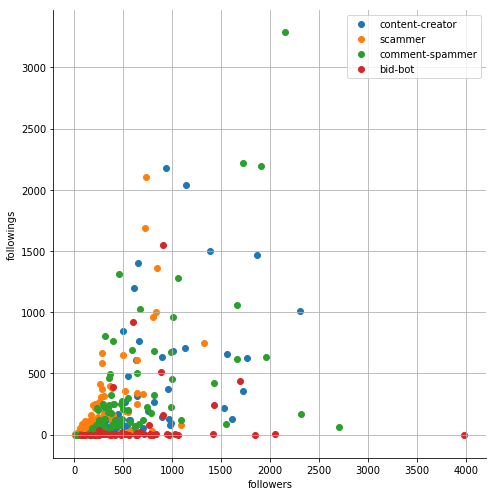

In [4]:
df1 = df[df['followings'] < 4000]
df1 = df1[df1['followers'] < 4000]
df1 = df1[df1['sp ratio'] < 200]
df1 = df1[df1['follow ratio'] < 3]
df1 = df1[df1['posting_rewards'] < 2000]
df1 = df1[df1['curation_rewards'] < 2000]
df1 = df1[df1['posts'] < 400]
df1 = df1[df1['comments'] < 8000]
df1 = df1[df1['average_post_len'] < 6000]
df1 = df1[df1['average_comment_len'] < 1000]
df1 = df1[df1['posts_to_comments_ratio'] < 10]

def add_legend():
    plt.legend(['content-creator', 'scammer', 'comment-spammer', 'bid-bot'])
    
def make_scatter_plot(d, x, y):
    sns.FacetGrid(d, hue="class", size=7).map(plt.scatter, x, y)
    add_legend()

make_scatter_plot(df1, 'followers', 'followings')

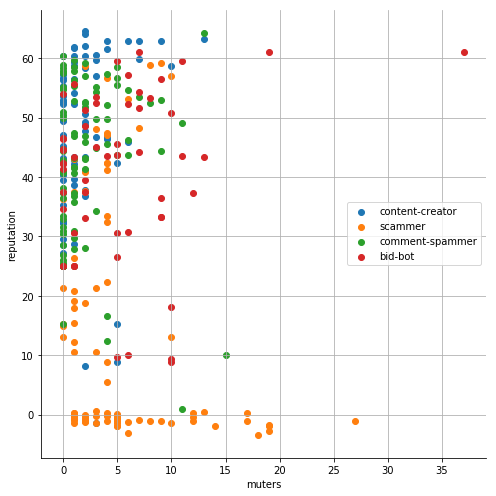

In [5]:
make_scatter_plot(df1, 'muters', 'reputation')

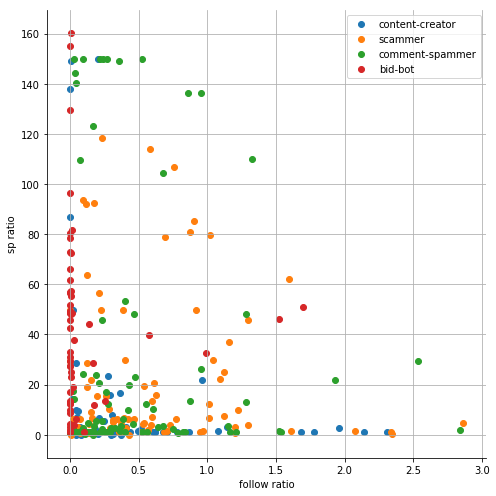

In [6]:
make_scatter_plot(df1, 'follow ratio', 'sp ratio')

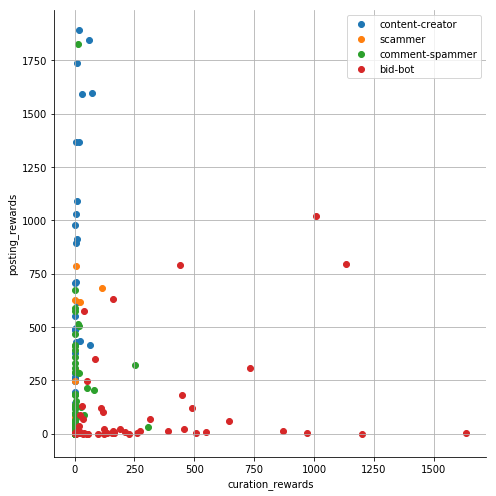

In [7]:
make_scatter_plot(df1, 'curation_rewards', 'posting_rewards')

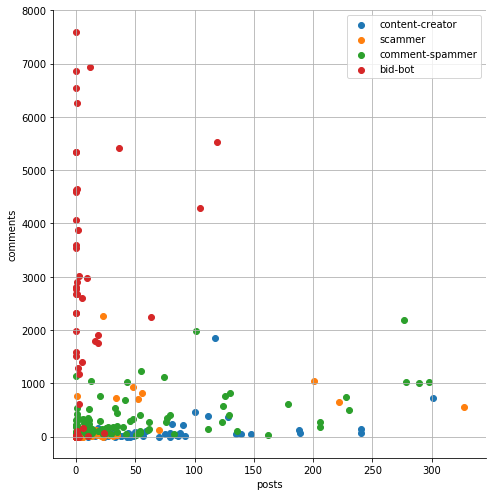

In [8]:
make_scatter_plot(df1, 'posts', 'comments')

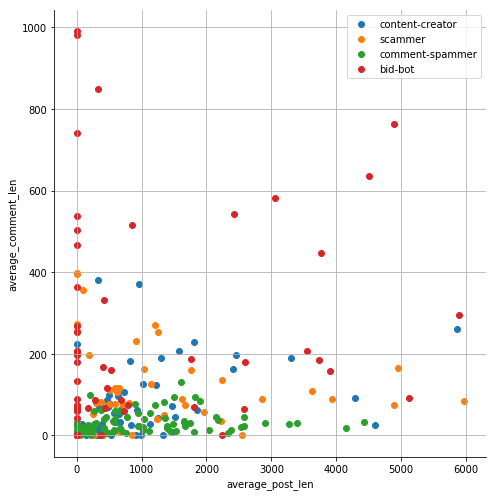

In [9]:
make_scatter_plot(df1, 'average_post_len', 'average_comment_len')

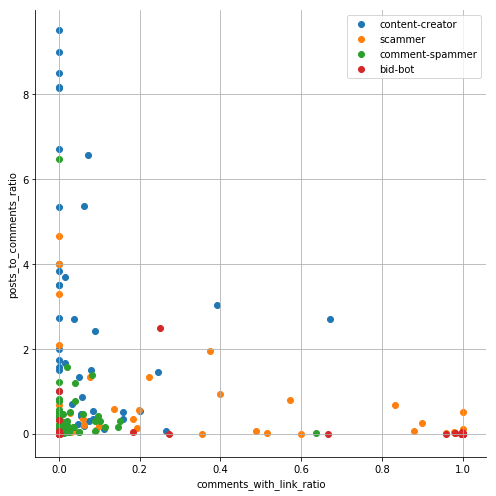

In [10]:
make_scatter_plot(df1, 'comments_with_link_ratio', 'posts_to_comments_ratio')

In [11]:
X_cols = columns
y_cols = ['class']
X = pd.DataFrame(QuantileTransformer().fit_transform(df[X_cols]))
y = to_categorical(df[y_cols])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)
input_dim = len(X_cols)

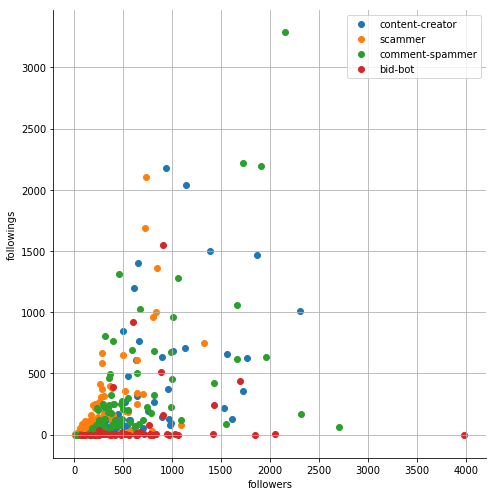

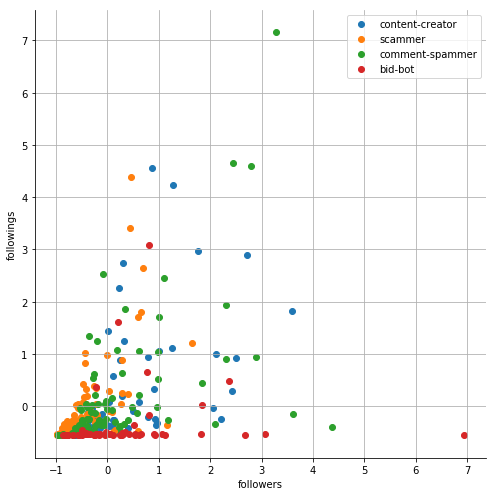

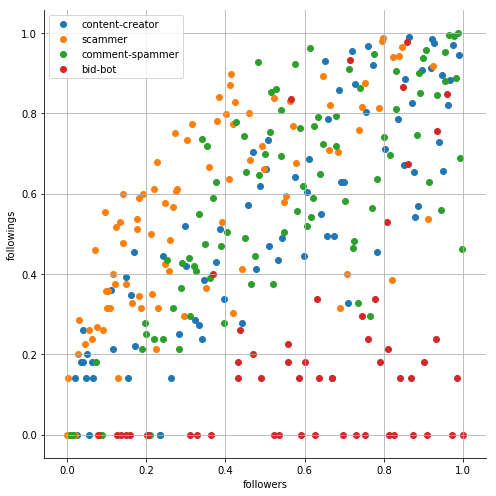

In [12]:
df_raw = df1.copy()

df_StandardScaler = df_raw.copy()
df_QuantileTransformer = df_raw.copy()

df_StandardScaler[X_cols] = StandardScaler().fit_transform(df_raw[X_cols])
df_QuantileTransformer[X_cols] = QuantileTransformer().fit_transform(df_raw[X_cols])

make_scatter_plot(df_raw , 'followers', 'followings')
make_scatter_plot(df_StandardScaler, 'followers', 'followings')
make_scatter_plot(df_QuantileTransformer, 'followers', 'followings')

In [13]:
ticklabels = ['content-creator', 'scammer', 'comment-spammer', 'bid-bot']

def plot_confusion_matrix(cm):
    plt.figure(figsize = (10, 10))
    sns.heatmap(cm,
                annot=True,
                cmap="Greens",
                xticklabels=ticklabels,
                yticklabels=ticklabels)

accuracy: 0.77


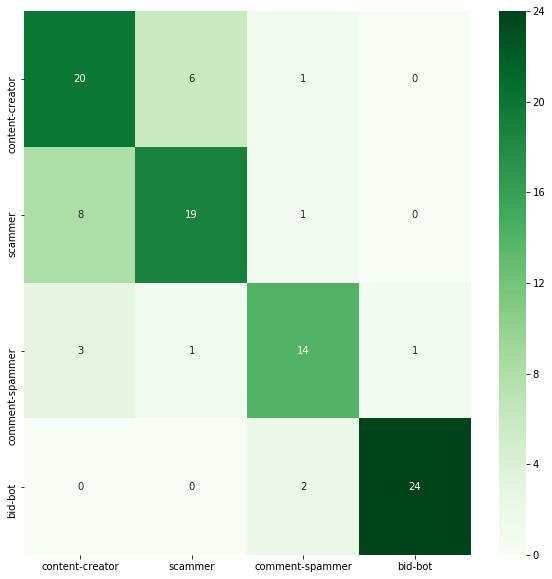

In [14]:
model = Sequential()
model.add(Dense(85, input_dim=17, activation='relu'))
model.add(Dense(40, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(X_train, y_train,epochs=40, batch_size=1, verbose=0)
score = model.evaluate(X_test, y_test,verbose=0)
y_pred = model.predict_classes(X_test)

print('accuracy: %.2f' % score[1])
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
plot_confusion_matrix(cm)

Optimizer|Accuracy
-|-
sgd|0.82
rmsprop|0.78
adagrad|0.80
adadelta|0.80
adam|0.80
adamax|0.81
nadam|0.81


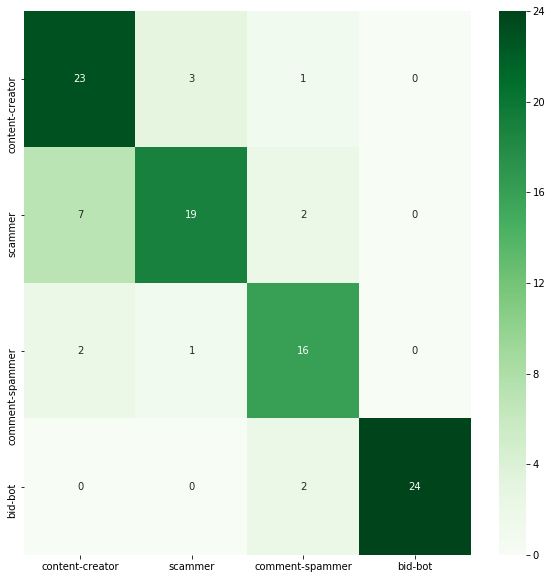

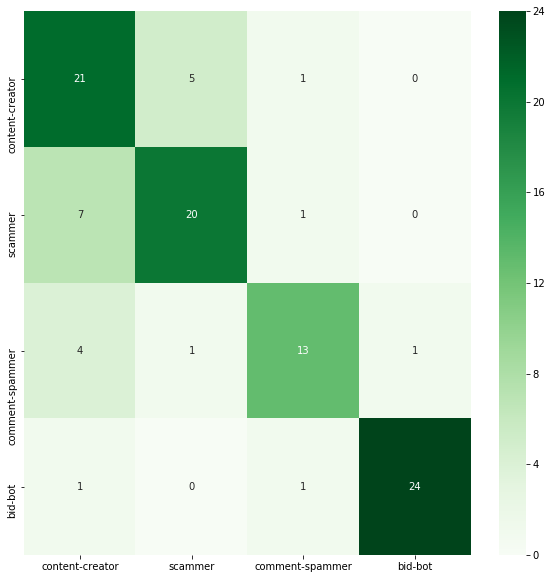

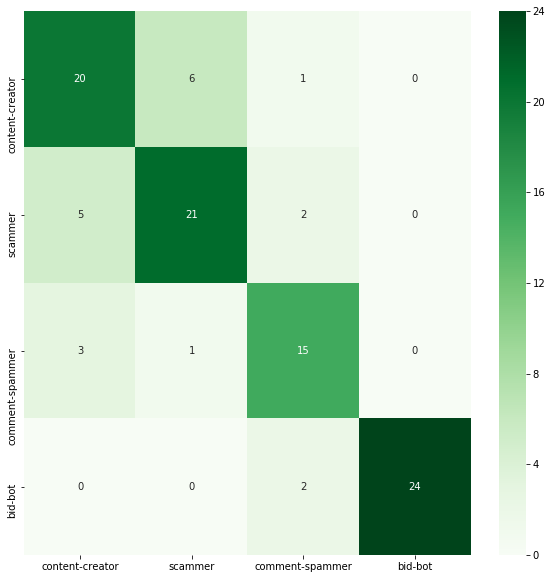

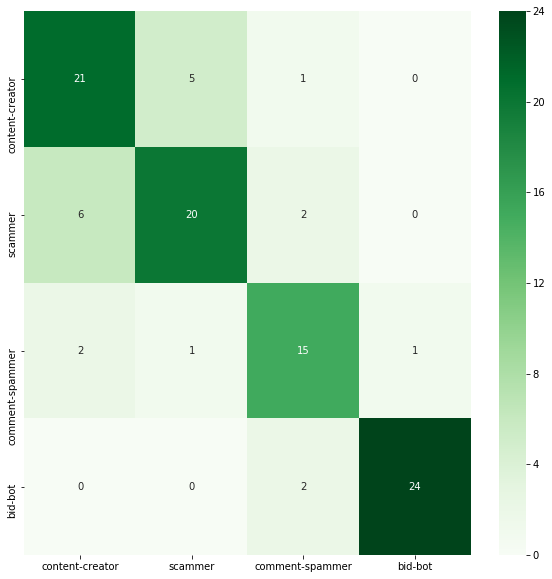

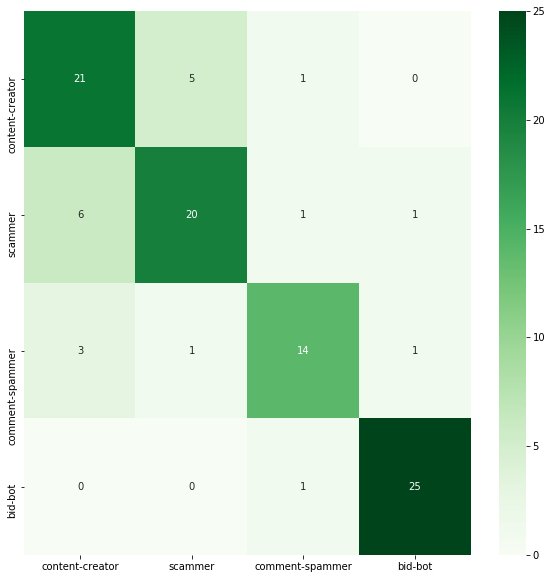

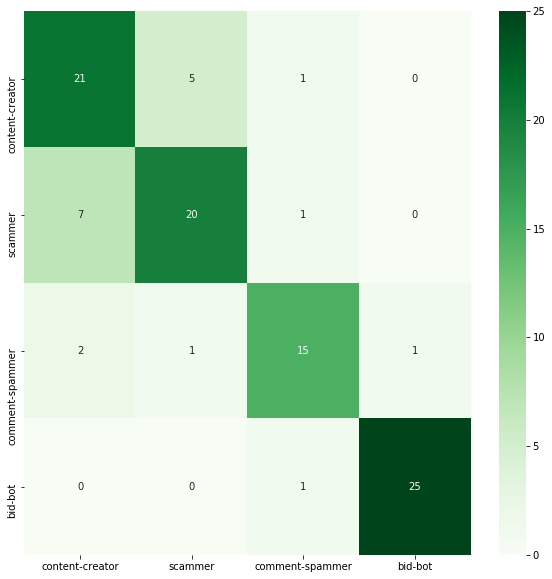

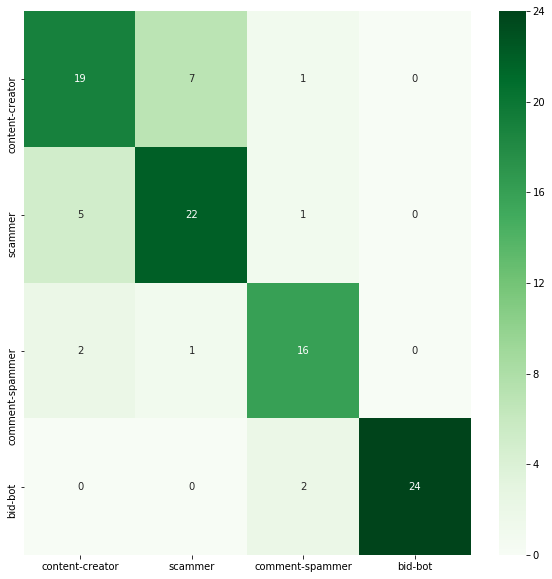

In [15]:
print('Optimizer|Accuracy')
print('-|-')
for optimizer in ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']:
    model = Sequential()
    model.add(Dense(85, input_dim=17, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(20, activation='relu'))
    model.add(Dense(4, activation='softmax'))

    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
           
    model.fit(X_train, y_train,epochs=40, batch_size=1, verbose=0)
    score = model.evaluate(X_test, y_test,verbose=0)
    y_pred = model.predict_classes(X_test)
    cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
    plot_confusion_matrix(cm)
    print('%s|%.2f' % (optimizer, score[1]))